# Feature importance methods

<div class="alert alert-block alert-warning">
  
<b>Notebook objectives:</b>
    
* Run a Pearson binary correlation to assess feature importance at a category level
    
* Drop the regularized categories from the data and export a new data set    

# 1. Notebook set up

In [1]:
# Try downgrading pandas version if pickle throws an error while loading
# !pip install pandas==1.4.1

In [25]:
###### Import packages

# Data handling
import numpy as np
import pandas as pd
import datetime as dt
#from IPython.display import HTML, Image #display formatted texts
import warnings
warnings.filterwarnings('ignore')

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty graphs
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Files to pickle
import pickle
import bz2
import _pickle as cPickle

# sampling
from sklearn.model_selection import train_test_split

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score
from sklearn.inspection import partial_dependence

# Load bars
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import time


from scipy import stats

# Path set up
path = "/project/data/"
path_w1 = "/project/data/w1/"
path_w2 = "/project/data/w2/"
path_w3 = "/project/data/w3/"
path_w4 = "/project/data/w4/"
path_w5 = "/project/data/w5/"
path_feature = "/project/data/feature_importance/"
json_path = "/project/notebooks/map/KEYFILE.json"

# fixed values
seed = 2323
colors = {'c1':['blue', 'red'], 'c2': ['red', 'blue', 'grey', 'purple']}
bar_width = 0.3
bin_num = 25
size = {'small_tick': 9, 'tick': 10 , 'label': 14, 'sub_title': 16, 'main_title': 20}
fig_size = {'large': (30,25), 'small': (10, 5)}

# pandas display set up
pd.options.display.max_columns = None

# 2. Loading pre-processed X and y

In [2]:
### Loading pickle files that will be clean and preprocess for ML modeling

# load pickled data for w1
pickled_data = bz2.BZ2File(path_w2 + 'strata_target_w2_1pct', 'rb')
sample_df = cPickle.load(pickled_data)
sample_df.drop(list(sample_df.filter(regex = 'ID')), axis = 1, inplace = True) # removes ID columns that do not hold explanatorry value
pickled_data.close()

In [3]:
# make a new reference to the data set
data = sample_df.reset_index()
print(F'Sample data set size:\n\
{data.shape[0]} rows\n\
{data.shape[1]} columns')

Sample data set size:
397979 rows
42 columns


In [4]:
# Loading X
pickled_data_X = bz2.BZ2File(path_w2 + 'X_train_dense_w2_1pct', 'rb')
X = cPickle.load(pickled_data_X)
pickled_data_X.close()
X.reset_index(drop = True, inplace =  True)
print(F"X shape: rows {X.shape[0]}, columns {X.shape[1]}")

X shape: rows 338282, columns 304


In [5]:
# Loading y (target)
pickled_data_y = bz2.BZ2File(path_w2 + 'y_train_dense_w2_1pct', 'rb')
y = cPickle.load(pickled_data_y)
pickled_data_y.close()
y.reset_index(drop = True, inplace =  True)
print(F"y shape: rows {y.shape[0]}, columns 1")

y shape: rows 338282, columns 1


# 2. Data cleaning

In [6]:
def clean_data_step(df):
    
    # 1. mapping features renamed
    
    # mapper to rename columns
    dict_features = {'Advertiser Currency': 'ad_currency', 'Date': 'date', 'Time of Day': 'tod', 'Advertiser': 'advertiser_name', 'Campaign': 'campaign_name', 
                    'Insertion Order': 'insertion_order', 'Line Item': 'line_item', 'Line Item Type': 'line_item_type', 'Platform': 'platform',
                    'Device Type': 'device_type', 'Device Make': 'device_make', 'Device Model': 'device_model', 'Operating System': 'os', 'Browser': 'browser',
                    'ISP or Carrier': 'isp_carrier', 'Environment': 'environment', 'Creative Type': 'creative_type', 'Creative': 'creative_name', 'Creative Size': 'creative_size',
                    'App/URL': 'app_url', 'Channel Type': 'channel_type', 'Channel': 'channel_name', 'Exchange': 'exchange', 'Inventory Source': 'inventory_source',
                    'Ad Position': 'ad_position', 'Ad Type': 'ad_type', 'Inventory Source Type': 'inventory_source_type', 'Position in Content': 'position_in_content',
                    'Public Inventory': 'public_inventory', 'Country': 'country', 'City': 'city', 'Impressions': 'impressions', 'Billable Impressions': 'billable_impressions',
                    'Active View: Viewable Impressions': 'viewable_impressions', 'Clicks': 'clicks', 'Total Conversions': 'total_conversions', 
                    'Post-Click Conversions': 'post_click_conversions', 'Post-View Conversions': 'post_view_conversions', 
                    'Revenue (Adv Currency)': 'media_cost', 'Media Cost (Advertiser Currency)': 'total_media_cost'}
    
    # rename columns to ease future referencing
    df.rename(columns = dict_features, inplace = True)
    
    # 2. Truncated instances are dropped which represent ~0.00008% fo total data set size
    df.dropna(inplace=True)
    
    # 3. Droppping unique value categorical features
    unique_v_df = pd.DataFrame(df.nunique()).rename(columns={0: "unique_values_count"})
    drop_unique_list = unique_v_df[unique_v_df['unique_values_count'] == 1].index.values.tolist()
    df.drop(drop_unique_list, axis=1, inplace = True)
    
    # 4. changing data timestamp format
    df['date'] = pd.to_datetime(df['date'])

    # 5. setting day/month/year format
    df['date'] = df['date'].dt.strftime('%d/%m/%Y')
    # return as date timestampe format
    df['date'] = pd.to_datetime(df['date'], format = "%d/%m/%Y")
    
    # 6. transforming floats to integers
    exclude_num_cols = ['media_cost','total_media_cost','index']
    float_cols = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var not in exclude_num_cols]
    
    # 7. transfor floats to int
    try:
        for col in float_cols:
            df[col] = df[col].astype('int64')
    except ValueError as excp:
        print('Make sure to pass columns with float dtype only') # friendly error message
        print(excp) # technical message as output
        print(type(excp)) # type error as output
    else:
        pass#print(F'{len(float_cols)} features tranformed to int64 dtype')
        
        
    # 8. Anonymizing data
    
    # insertion order
    insertion_orders = {n:"insertion_order{}".format(i+1) for i, n in enumerate(df['insertion_order'].unique())}
    df["insertion_order"] = df['insertion_order'].map(insertion_orders)
    
    # anonymizing line items
    line_items = {n:"line_item{}".format(i+1) for i, n in enumerate(df['line_item'].unique())}
    df["line_item"] = df['line_item'].map(line_items)
    
    # anonymizing creatives
    creatives = {n:"creative_name{}".format(i+1) for i, n in enumerate(df['creative_name'].unique())}
    df["creative_name"] = df['creative_name'].map(creatives)
    
    
    # 9. converting to string data types
    df['day_of_week'] = df['date'].dt.day_name()
    df['date'] = df['date'].dt.strftime('%d/%m/%Y')
    
    mapped_times = {n:"tod_{}".format(i+1) for i, n in enumerate(df['tod'].unique())}
    df["tod"] = df['tod'].map(mapped_times)

    
    # 10. Get the target feature
    df['user_response'] = np.where(df['clicks'] == 0, 0, 1) # generates target feature
    
    #11. log transform
    log_transform_list = ['media_cost', 'total_media_cost']
    
    for col in log_transform_list:
        df[col+'_log'] = np.log(df[col]+0.000001)
        
        df.drop([col], axis = 1, inplace = True) 
    
    
    #return cleaned df
    print(f'cleaned data set with {df.shape[0]} rows and {df.shape[1]} columns.')
    return df

In [7]:
# Defining custom cleaning step transformer
preprocessing = FunctionTransformer(clean_data_step)

In [8]:
# fitting cleaning step transformer
df_prep = preprocessing.fit_transform(data)

cleaned data set with 397979 rows and 31 columns.


In [9]:
df_prep.head()

,index,date,tod,insertion_order,line_item,device_type,device_make,device_model,os,browser,isp_carrier,creative_name,creative_size,app_url,channel_name,exchange,inventory_source,ad_position,ad_type,position_in_content,city,impressions,billable_impressions,viewable_impressions,clicks,total_conversions,post_view_conversions,user_response,day_of_week,media_cost_log,total_media_cost_log
0,9401544,16/04/2022,tod_1,insertion_order1,line_item1,Smart Phone,Samsung (All Models),Samsung Galaxy A42 5G (SM-A426B),Android 12.0,Google Chrome,Virgin Media,creative_name1,320x50,liverpoolecho.co.uk,Top 2000 Global Sites for Nielsen Display Ads,TripleLift,Unknown or Unpermissioned Inventory Source,Unknown,Standard,Unknown - Out-stream,Unknown,1,1,1,0,0,0,0,Saturday,-6.146949,-6.237877
1,5488550,16/04/2022,tod_2,insertion_order2,line_item2,Smart Phone,Apple (All Models),Apple iPhone,iOS 14.7,Safari (iPhone/iPod),Mobile Other,creative_name2,320x100,dailymail.co.uk/tvshowbiz,Top 2000 Global Sites for Nielsen Display Ads,Google Ad Manager,Unknown or Unpermissioned Inventory Source,BELOW_THE_FOLD,Standard,Unknown - Out-stream,Douglas,1,1,1,0,0,0,0,Saturday,-10.519674,-10.596635
2,4792812,16/04/2022,tod_3,insertion_order3,line_item3,Smart Phone,Apple (All Models),Apple iPhone,iOS 15.4,Safari (iPhone/iPod),BT,creative_name3,300x250,lincolnshirelive.co.uk,GroupM_Inclusion List,Google Ad Manager,Unknown or Unpermissioned Inventory Source,ABOVE_THE_FOLD,Standard,Unknown - Out-stream,Unknown,4,4,4,0,0,0,0,Saturday,-7.443899,-7.535115
3,4104829,16/04/2022,tod_4,insertion_order3,line_item4,Smart Phone,Samsung (All Models),Samsung Galaxy S20 FE 5G (SM-G781B),Android 12.0,Google Chrome,BT,creative_name2,320x100,manchestereveningnews.co.uk,Top 2000 non-US Sites for Nielsen Video Ads,Google Ad Manager,Unknown or Unpermissioned Inventory Source,BELOW_THE_FOLD,Standard,Unknown - Out-stream,Manchester,1,1,1,0,0,0,0,Saturday,-9.293722,-9.384694
4,546638,16/04/2022,tod_5,insertion_order2,line_item5,Smart Phone,Samsung (All Models),Samsung Galaxy A12 (SM-A125F),Android 11.0,Google Chrome,Virgin Media,creative_name1,320x50,unilad.co.uk,Top 2000 Global Sites for Nielsen Video Ads,PubMatic,Unknown or Unpermissioned Inventory Source,ABOVE_THE_FOLD,Standard,Unknown - Out-stream,Bolton,4,4,4,0,0,0,0,Saturday,-6.940278,-7.031053


In [10]:
# create a copy
df_copy = df_prep.copy()

In [11]:
# define list categorical and numerica features
numeric_cols = df_prep.select_dtypes(include=['int64', 'float64']).columns
catg_cols = df_prep.select_dtypes(include=['object']).columns

# filter categorical, numeric, and target
target = df_prep['user_response']
numeric_df = df_prep[numeric_cols]
numeric_df.drop(['user_response','clicks','index'],axis=1, inplace = True)
catg_df = df_prep[catg_cols]
catg_df.drop(['ad_type'],axis=1, inplace = True)

In [12]:
# correlations point biserial
numeric_correlations = pd.DataFrame()
cofs_corr = []
for col in numeric_df.columns: 
    cof_corr = stats.pointbiserialr(numeric_df[col],target)
    cofs_corr.append(round(cof_corr.correlation,5))
        
numeric_correlations['feature'] = numeric_df.columns 
numeric_correlations['correlation'] = cofs_corr

print(numeric_correlations)

                 feature  correlation
0            impressions      0.02354
1   billable_impressions      0.02354
2   viewable_impressions      0.02376
3      total_conversions     -0.00004
4  post_view_conversions     -0.00004
5         media_cost_log      0.01339
6   total_media_cost_log      0.01347


In [13]:
# Defining Pearson correlation compute function

categoric_correlation = pd.DataFrame()

name_value_cat = []
corr_cat_list = []

def PearsonBinary(x,y):
    values = []
    for i,j in zip(x,y):
        values.append((i,j))
    a = values.count((1,1))
    b = values.count((1,0))
    c = values.count((0,1))
    d = values.count((0,0))
    try:
        corr = (a*d - b*c)/(((a+c)*(b+d)*(a+b)*(c+d))**(1/2))
        #corr = a /(a+b+c+d)
    except Exception as e:
        corr = 1
        print(a)
        print(b)
        print(c) 
        print(d)
        
    return round(corr,5)

In [14]:
# pearson binary correlation
for col in tqdm(catg_df.columns):
    values = catg_df[col].unique()
    no_values = [None, 'NULL', 'NA', 'N/A']
    for x in values: 
        if x not in no_values:
            name = col + '-' + x 
            aux = catg_df[col].copy()
            aux = aux.apply(lambda y: 1 if y == x else 0)
            corr = PearsonBinary(aux, target)
            name_value_cat.append(name)
            corr_cat_list.append(corr)
#             print(corr)

categoric_correlation['feature'] = name_value_cat
categoric_correlation['correlation'] = corr_cat_list

100%|██████████| 20/20 [18:15<00:00, 54.80s/it] 


In [15]:
# merge numeric and categoric correlations
union = pd.concat([numeric_correlations, categoric_correlation])
pearson_binary_correlation = union.sort_values(by = 'correlation', ascending = False) #sort
pearson_binary_correlation

,feature,correlation
576,device_model-Vivo Y51A (V2031),0.03527
984,browser-Android Browser,0.02729
1481,app_url-saabcentral.com,0.02489
2,viewable_impressions,0.02376
0,impressions,0.02354
...,...,...
1040,creative_size-320x50,-0.00527
1030,creative_name-creative_name1,-0.00544
33,insertion_order-insertion_order3,-0.00625
3243,inventory_source-Unknown or Unpermissioned Inv...,-0.00650


In [16]:
# export to csv
pearson_binary_correlation.to_csv(path_feature + 'pearson_binary_feature_correlation.csv', index = True, index_label = False)

### Load pearson binary correlation df

In [3]:
# load correlation csv
data = pd.read_csv(path_feature + "pearson_binary_feature_correlation.csv")

In [5]:
data.head(5)

,feature,correlation
576,device_model-Vivo Y51A (V2031),0.03527
984,browser-Android Browser,0.02729
1481,app_url-saabcentral.com,0.02489
2,viewable_impressions,0.02376
0,impressions,0.02354


In [18]:
t5 = data.head(5).reset_index(drop=True)
t5

,feature,correlation
0,device_model-Vivo Y51A (V2031),0.03527
1,browser-Android Browser,0.02729
2,app_url-saabcentral.com,0.02489
3,viewable_impressions,0.02376
4,impressions,0.02354


In [21]:
b5 = data.sort_values(by=['correlation'], ascending = True) 
b5 = b5.head(5).reset_index(drop=True)
b5

,feature,correlation
0,ad_position-BELOW_THE_FOLD,-0.00681
1,inventory_source-Unknown or Unpermissioned Inv...,-0.00650
2,insertion_order-insertion_order3,-0.00625
3,creative_name-creative_name1,-0.00544
4,creative_size-320x50,-0.00527


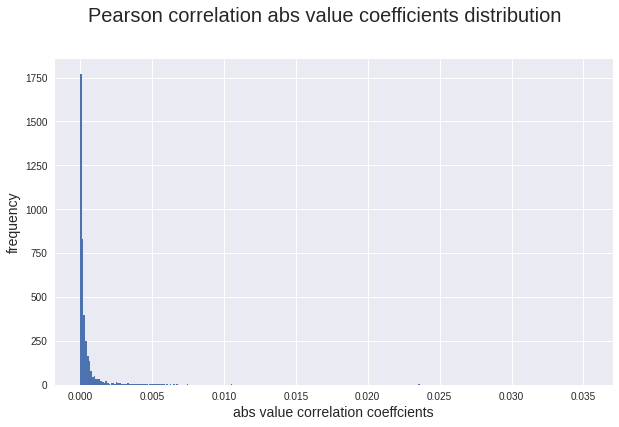

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(data['correlation'], bins=300)
ax.set_ylabel('frequency', fontsize = size['label'])
ax.set_xlabel('abs value correlation coeffcients', fontsize = size['label'])
fig.suptitle('Pearson correlation abs value coefficients distribution', fontsize = size['main_title'], y = 0.9999)
plt.show()

In [23]:
# transform correlation to absolute
data['correlation'] = data['correlation'].apply(lambda x: abs(x))
# get percentil to define threshold
percentil = np.percentile(data['correlation'],10)
percentil

4e-05

In [24]:
# Define threshold and grouped features
threshold = percentil
filtered_features = data[data['correlation'] < threshold]
kept_features = data[data['correlation'] >= threshold]

# grouped df with unique values marked under the threshold
grouped_corr_features = filtered_features[['correlation','feature']].groupby(['feature','correlation']).count().reset_index().rename(columns ={'feature': 'num_categories'})
grouped_corr_features

,num_categories,correlation
0,city-Norwich,0.00003
1,creative_name-creative_name8,0.00003
2,device_make-HUAWEI (All Models),0.00000
3,isp_carrier-Vodafone in GB,0.00003


In [25]:
# data handling to separate column and category value
filtered_features['column'] = filtered_features['feature'].apply(lambda x: x[:x.find('-')])
filtered_features['category'] = filtered_features['feature'].apply(lambda x: x[x.find('-')+1:])

# append index values from categories marked as low correlation
list_indexes = []
for x, y in zip(filtered_features['column'],filtered_features['category']):
    try: 
        selectedrows = df_copy[df_copy[x] == y].index.tolist()
        list_indexes.append(selectedrows) 
    except:
        pass
        
# get unique index in a list
flat_indexes = [item for sub_list in list_indexes for item in sub_list ]
unique_indexes = list(set(flat_indexes))

# drop index in a new df
df_prep_dropped = df_prep.drop(unique_indexes, axis=0)

# print total removed instances
print(F"Total removed intances: {df_prep.shape[0] - df_prep_dropped.shape[0]}")

Total removed intances: 91445


In [27]:
# Exporting dropped features regularized dataframe
sfile = bz2.BZ2File(path_w2 + 'df_prep_dropped', 'w')
pickle.dump(df_prep_dropped,sfile)
sfile.close()